###  Using the class spectral analysis

Tutorial on how to use the spectral analysis class to compute power spectrum, spectogram, and the pairwise coherence.

In [1]:
%matplotlib inline

import numpy               as     np
import matplotlib.pyplot   as     plt
from GDa.spectral_analysis import spectral, spectral_analysis
from GDa.session           import session

The class __spectral_analysis__ inherits from a more general class named __spectral__. Let's start by using the __spectral__ class:

In [2]:
spec = spectral()

To use the object __spec__ first we read a sample LFP signal:

In [3]:
data = np.load('raw_lfp/lucy_session01_150304.npy',allow_pickle=True).item()['data']
N    = data.shape[2]   # Number of time points 
fs   = 1000            # Sampling frequency  [Hz]

Next, we will select a random LFP signal in data:

In [4]:
lfp   = data[np.random.randint(0, data.shape[0]),np.random.randint(0, data.shape[1]),:]
lfp2  = data[np.random.randint(0, data.shape[0]),np.random.randint(0, data.shape[1]),:]
# Time axis, using from -0.65 to 3.00 s because this is the event dt we used when we saved the data
time = np.linspace(-0.65, 3.00, lfp.shape[-1]) 

Text(0, 0.5, 'mV')

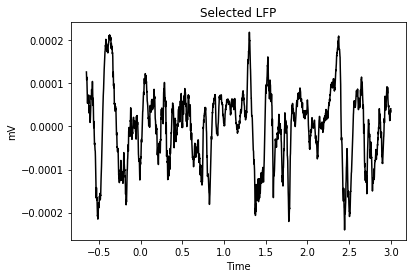

In [5]:
# Plotting the signal
plt.plot(time, lfp, 'k')
plt.title('Selected LFP')
plt.xlabel('Time')
plt.ylabel('mV')

We can bandpass filter the signal with the function __filter__ in __spectral__, let's filter it on the alpha band (8-12 Hz):

In [6]:
lfp_filterd = spec.filter(signal = lfp, fs = fs, f_low = 8, f_high = 12, n_jobs = -1)

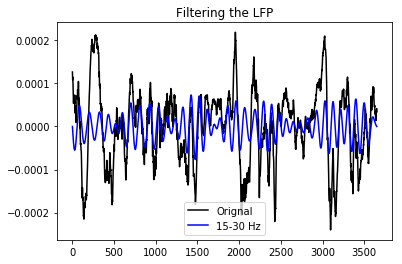

In [7]:
plt.plot(lfp, 'k')
plt.plot(lfp_filterd, 'b')
plt.title('Filtering the LFP')
plt.legend(['Orignal', '15-30 Hz'])

We can compute the spectogram of the signal using the function __spectogram__, it is possible to use morlet or multitaper transforms.



In [8]:
freqs = np.arange(4,30,.1)

W_morlet     = spec.wavelet_spectrum(signal1 = lfp[np.newaxis, np.newaxis, :], signal2 = None, 
                                     fs = fs, freqs = freqs, n_cycles = freqs/2.0,
                                     smooth_window = 500, time_bandwidth = None, method = 'morlet', n_jobs = -1)

W_multitaper = spec.wavelet_spectrum(signal1 = lfp[np.newaxis, np.newaxis, :], signal2 = None, 
                                     fs = fs, freqs = freqs, n_cycles = freqs/2.0,
                                     smooth_window = 500, time_bandwidth = 8.0, method = 'multitaper', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.4s finished


Next, we can visualize the result:

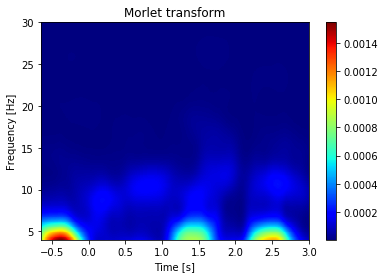

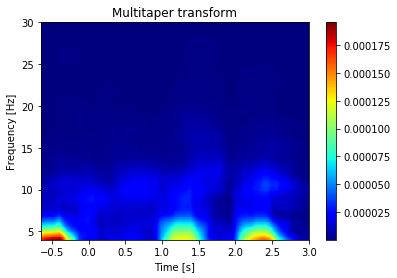

In [9]:
plt.figure()
plt.title('Morlet transform')
plt.imshow(np.squeeze(W_morlet.real), aspect='auto', cmap='jet', origin='lower', extent=[-0.65, 3.00, 4, 30])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar()
plt.figure()
plt.title('Multitaper transform')
plt.imshow(np.squeeze(W_multitaper.real), aspect='auto', cmap='jet', origin='lower', extent=[-0.65, 3.00, 4, 30])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar()

Finally we can compute the time-frequency coherence between two signals by using the function __coherence__:

In [10]:
coh_morlet     = spec.coherence(signal1=lfp[np.newaxis, np.newaxis, :], 
                                signal2=lfp2[np.newaxis, np.newaxis, :],
                                fs=fs,freqs=freqs,n_cycles=freqs/2.0,
                                smooth_window = 500, method='morlet',n_jobs=-1)
coh_multitaper = spec.coherence(signal1=lfp[np.newaxis, np.newaxis, :], 
                                signal2=lfp2[np.newaxis, np.newaxis, :],
                                fs=fs,freqs=freqs,n_cycles=freqs/2.0, time_bandwidth=8.0,
                                smooth_window = 500, method='multitaper',n_jobs=-1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.4s finished


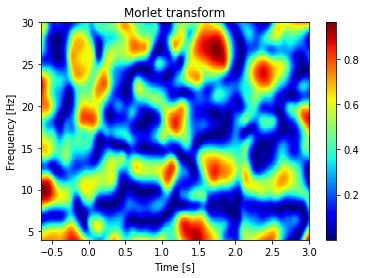

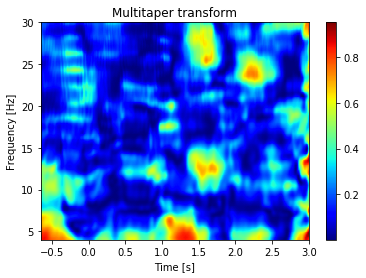

In [11]:
plt.figure()
plt.title('Morlet transform')
plt.imshow(np.squeeze(coh_morlet.real), aspect='auto', cmap='jet', origin='lower', extent=[-0.65, 3.00, 4, 30])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar()
plt.figure()
plt.title('Multitaper transform')
plt.imshow(np.squeeze(coh_multitaper.real), aspect='auto', cmap='jet', origin='lower', extent=[-0.65, 3.00, 4, 30])
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.colorbar()

For all the functions above we can use only one signal as input or for a matrix with dimensions [N_trials, N_channels, time].

The __spectral_analysis__ class inherits the functions from __spectral__ however it is more focused on appling then efficiently to the LFP data. We can instatiate the __spectral_analysis__ class by either passing an session object to it, or by reading the data file saved by the session object (see notebook 1).

In [12]:
# 1. INSTATIATING SPECTRAL_ANALYSIS USING A SESSION OBJECT

ses = session(raw_path = 'GrayLab/', monkey = 'lucy', stype = 'samplecor', date = '150128', 
              session = 1, evt_dt = [-0.65,3.00])

ses.read_session_info()
ses.read_lfp_data()

spec = spectral_analysis(session = ses, path = None, freqs = freqs, delta=15)

In [13]:
# 2. INSTATIATING SPECTRAL_ANALYSIS USING THE DATA FILE FROM SESSION

spec = spectral_analysis(session = None, path = 'raw_lfp/lucy_session01_150304.npy', freqs = freqs, delta=15)

We can do all the operations we did with the __spectral__ object easily now. The operations are done by giving the trial, and channels number in which they should be performed. Let's starting by filtering a random signal in the alpha band.

In [14]:
lfp_filterd = spec._filter(trial = np.random.randint(0, data.shape[0]), 
                          index_channel = np.random.randint(0, data.shape[1]),
                          apply_to_all = False,
                          f_low = 8, f_high = 12, n_jobs = 1)

Filtering the signal

Text(0, 0.5, 'mV')

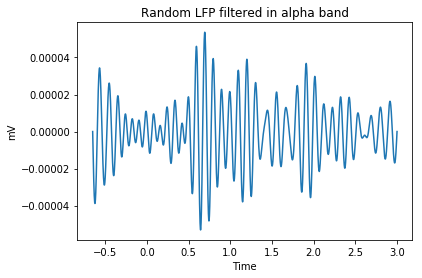

In [15]:
plt.plot(time, lfp_filterd )
plt.title('Random LFP filtered in alpha band')
plt.xlabel('Time')
plt.ylabel('mV')

Computing spectogram

In [16]:
idx = 30

W_morlet = spec._wavelet_spectrum(trial = 0, 
                 index_channel1 = idx, 
                 index_channel2 = None, 
                 n_cycles = freqs, 
                 smooth_window = 500, time_bandwidth = None, 
                 method = 'morlet', n_jobs = -1)

W_multitaper= spec._wavelet_spectrum(trial = 0, 
                 index_channel1 = idx, 
                 index_channel2 = None, 
                 n_cycles = freqs, 
                 smooth_window = 500, time_bandwidth = 8.0, 
                 method = 'multitaper', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.6s finished


Text(0.5, 0, 'Time [s]')

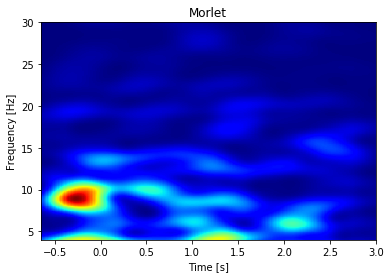

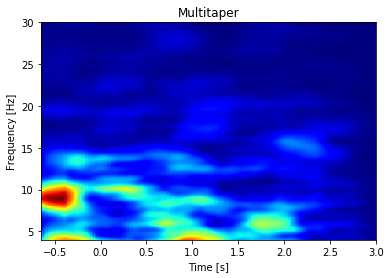

In [18]:
plt.title('Morlet')
plt.imshow(np.squeeze(W_morlet.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.figure()
plt.title('Multitaper')
plt.imshow(np.squeeze(W_multitaper.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

If we indicate a second channel number both auto-(for each signal), and the cross-spectrum will be computed

In [19]:
Sxx, Syy, Sxy = spec._wavelet_spectrum(trial = 0, 
                                       index_channel1 = 10, 
                                       index_channel2 = 30, 
                                       n_cycles = freqs, 
                                       smooth_window = 500, time_bandwidth = None, 
                                       method = 'morlet', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    1.4s finished


Text(0.5, 1.0, '$S_{xy}$')

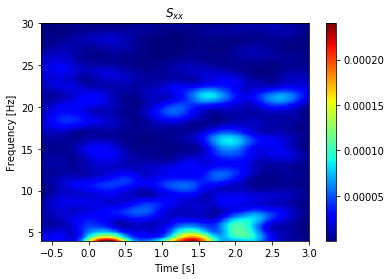

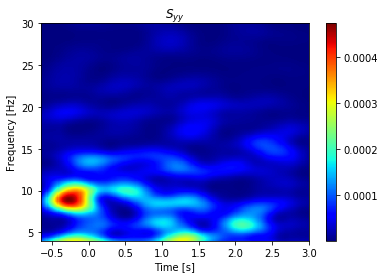

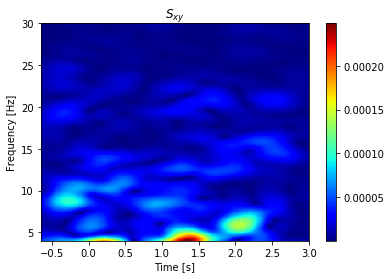

In [20]:
plt.figure()
plt.imshow(np.squeeze(Sxx.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('$S_{xx}$')
plt.figure()
plt.imshow(np.squeeze(Syy.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('$S_{yy}$')
plt.figure()
plt.imshow(np.squeeze(np.abs(Sxy)), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('$S_{xy}$')

In [21]:
Sxx, Syy, Sxy = spec._wavelet_spectrum(trial = 0, 
                                       index_channel1 = 10, 
                                       index_channel2 = 30, 
                                       n_cycles = freqs, 
                                       smooth_window = 500, time_bandwidth = 8.0, 
                                       method = 'multitaper', n_jobs = -1)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.4s finished
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   1 out of   1 | elapsed:    2.4s finished


Text(0.5, 1.0, '$S_{xy}$')

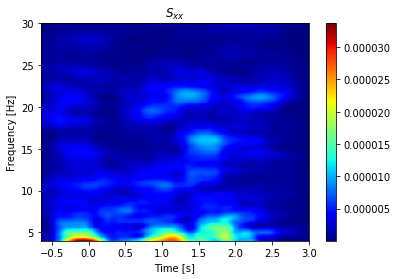

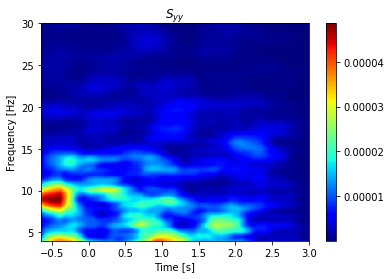

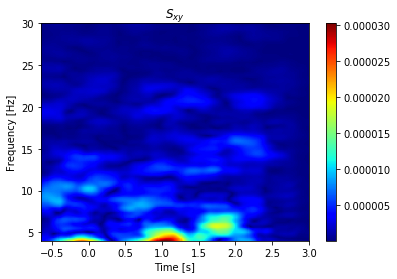

In [22]:
plt.figure()
plt.imshow(np.squeeze(Sxx.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('$S_{xx}$')
plt.figure()
plt.imshow(np.squeeze(Syy.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('$S_{yy}$')
plt.figure()
plt.imshow(np.squeeze(np.abs(Sxy)), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('$S_{xy}$')

Finally, we can compute the coherence between a pair of signals

In [61]:
coh_morlet = spec._coherence(trial = 0, 
                             index_pair = 624, 
                             n_cycles = freqs/2.0, smooth_window = 500, 
                             time_bandwidth = None, method = 'morlet', n_jobs = 1)

coh_multitaper = spec._coherence(trial = 0, 
                                 index_pair = 624, 
                                 n_cycles = freqs/2.0, smooth_window = 500, 
                                 time_bandwidth = 8.0, method = 'multitaper', n_jobs = 1)

Text(0.5, 1.0, 'Multitaper')

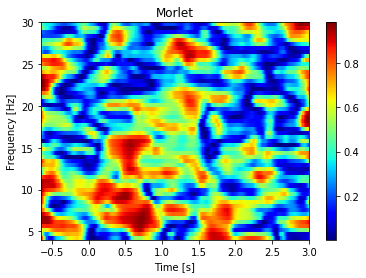

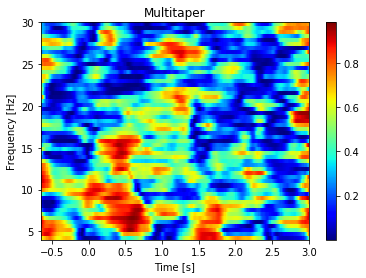

In [62]:
plt.figure()
plt.imshow(np.squeeze(coh_morlet.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Morlet')
plt.figure()
plt.imshow(np.squeeze(coh_multitaper.real), aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65, 3.00, 4, 30])
plt.colorbar()
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Multitaper')

We can use the spectral analysis class to compute the pairwise coherence for the whole session with the method __session_coherence__.